# Kepler Framework Examples

In [65]:
import os
import gc
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kepler 

from pprint import pprint
from copy import deepcopy

import mplhep as hep
plt.style.use(hep.style.ROOT)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
l_path  = "/home/micael/Documents/NeuralRinger/Jpsiee"

data_path    = os.path.join(l_path, 
                            "data")
analysis_path = os.path.join(l_path, 
                            "analysis/v1/r0")

dpath = os.path.join(data_path, 
"data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM2.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.15bins/data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM2.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.15bins_et{ET}_eta{ETA}.npz")


tpath = os.path.join(analysis_path, 'export_v1.r0.mlp2_11012022/ElectronRinger{OP_NAME}TriggerConfig.conf')

## Setup Ringer v1:

In [3]:
def my_generator( df ):
    col_names= ["trig_L2_cl_ring_%d"%i for i in range(100)]
    rings = df[col_names].values.astype(np.float32)
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    rings = norm1(rings)
    return [rings]

decorators = []
for iname, iop in zip(['tight', 'medium', 'loose', 'vloose'], ['Tight', 'Medium', 'Loose', 'VeryLoose']):
    decorators.append(kepler.pandas.RingerDecorator(column='ringer_v1_%s' %(iname), path=tpath.format(OP_NAME=iop), generator=my_generator))

2022-01-12 13:55:33,683 | Py.RingerDecorator                      INFO Reading... /home/micael/Documents/NeuralRinger/Jpsiee/analysis/v1/r0/export_v1.r0.mlp2_11012022/ElectronRingerTightTriggerConfig.conf
2022-01-12 13:55:34,400 | Py.RingerDecorator                      INFO Reading... /home/micael/Documents/NeuralRinger/Jpsiee/analysis/v1/r0/export_v1.r0.mlp2_11012022/ElectronRingerMediumTriggerConfig.conf
2022-01-12 13:55:34,617 | Py.RingerDecorator                      INFO Reading... /home/micael/Documents/NeuralRinger/Jpsiee/analysis/v1/r0/export_v1.r0.mlp2_11012022/ElectronRingerLooseTriggerConfig.conf
2022-01-12 13:55:34,829 | Py.RingerDecorator                      INFO Reading... /home/micael/Documents/NeuralRinger/Jpsiee/analysis/v1/r0/export_v1.r0.mlp2_11012022/ElectronRingerVeryLooseTriggerConfig.conf


2022-01-12 13:55:33.699589: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-12 13:55:33.735676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 13:55:33.735965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2022-01-12 13:55:33.736006: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-12 13:55:33.737668: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-12 13:55:33.738556: I tensorflow/stream_executor/platform/d

## Setup Chains:

In [14]:
# create my chain
m_ringer_chain   = kepler.pandas.menu.ElectronSequence( "HLT_e5_lhtight_nod0_ringer_v1", 
                                                        L1Seed = 'L1_EM3', 
                                                        l2calo_column = 'ringer_v1_tight' )
m_noringer_chain = kepler.pandas.menu.ElectronSequence( "HLT_e5_lhtight_nod0_noringer", 
                                                        L1Seed = 'L1_EM3')

chains = [m_ringer_chain, m_noringer_chain]

OrderedDict([('L1Seed', 'L1_EM3'),
             ('L2Calo', (2000.0, 'ringer_v1_tight')),
             ('L2', 'trig_L2_el_cut_pt0to15'),
             ('EFCalo', 5000.0),
             ('HLT', (5000.0, 'trig_EF_el_lhtight'))])
OrderedDict([('L1Seed', 'L1_EM3'),
             ('L2Calo', (2000.0, 'trig_L2_cl_lhtight_et0to12')),
             ('L2', 'trig_L2_el_cut_pt0to15'),
             ('EFCalo', 5000.0),
             ('HLT', (5000.0, 'trig_EF_el_lhtight'))])


## Read all bins:

In [19]:

def read_all_files( path , decorators, chains = []):#, drop_rings=True, drop_other_columns = [] ):
    import tqdm
    import itertools
    df_list = []
    for iet, ieta in tqdm.tqdm(list(itertools.product(range(3), range(5)))):    
        df_temp = kepler.load( path.format(ET=iet, ETA=ieta ) )
        df_temp['et_bin']  = iet
        df_temp['eta_bin'] = ieta
        # propagate ringer
        for dec in tqdm.tqdm(decorators):
            # Apply v1 column
            dec.apply( df_temp, batch_size=2048 )
                
            # emulate chains
        for chain in tqdm.tqdm(chains):
            chain.apply(df_temp)
                        
        df_list.append(df_temp)
            
    return pd.concat(df_list)
                           
m_df = read_all_files(dpath, decorators=decorators, chains=chains)#, drop_other_columns=drop_columns, drop_rings=True)    

100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


In [20]:
print(list(m_df.columns))

['RunNumber', 'avgmu', 'trig_L2_cl_et', 'trig_L2_cl_eta', 'trig_L2_cl_phi', 'trig_L2_cl_reta', 'trig_L2_cl_ehad1', 'trig_L2_cl_eratio', 'trig_L2_cl_f1', 'trig_L2_cl_f3', 'trig_L2_cl_weta2', 'trig_L2_cl_wstot', 'trig_L2_cl_e2tsts1', 'trig_L2_cl_ring_0', 'trig_L2_cl_ring_1', 'trig_L2_cl_ring_2', 'trig_L2_cl_ring_3', 'trig_L2_cl_ring_4', 'trig_L2_cl_ring_5', 'trig_L2_cl_ring_6', 'trig_L2_cl_ring_7', 'trig_L2_cl_ring_8', 'trig_L2_cl_ring_9', 'trig_L2_cl_ring_10', 'trig_L2_cl_ring_11', 'trig_L2_cl_ring_12', 'trig_L2_cl_ring_13', 'trig_L2_cl_ring_14', 'trig_L2_cl_ring_15', 'trig_L2_cl_ring_16', 'trig_L2_cl_ring_17', 'trig_L2_cl_ring_18', 'trig_L2_cl_ring_19', 'trig_L2_cl_ring_20', 'trig_L2_cl_ring_21', 'trig_L2_cl_ring_22', 'trig_L2_cl_ring_23', 'trig_L2_cl_ring_24', 'trig_L2_cl_ring_25', 'trig_L2_cl_ring_26', 'trig_L2_cl_ring_27', 'trig_L2_cl_ring_28', 'trig_L2_cl_ring_29', 'trig_L2_cl_ring_30', 'trig_L2_cl_ring_31', 'trig_L2_cl_ring_32', 'trig_L2_cl_ring_33', 'trig_L2_cl_ring_34', 'trig_L2

In [31]:
m_bins

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [36]:
m_df.loc[(m_df.target == 1) & (m_df.el_lhtight == 1)]['el_et']

0         6275.900879
1         5850.601074
3         6122.264160
4         6001.007324
6         6682.531250
             ...     
16370    12326.056641
16373    12852.642578
16374    12314.749023
16375    13621.239258
16376    14011.490234
Name: el_et, Length: 90632, dtype: float32

In [42]:
m_df.loc[(m_df.target == 1) & \
                                               (m_df.el_lhtight == 1) & \
                                               (m_df.L2Calo_e5_lhtight_nod0_ringer_v1 == 1)]['trig_L2_cl_et'].max()

14999.952

In [56]:
m_counts, t_counts, m_counts/t_counts

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]))

In [58]:
m_df.loc[(m_df.target == 1) & (m_df.el_lhtight == 1)]['el_et']/GeV

0         6.275901
1         5.850601
3         6.122264
4         6.001007
6         6.682531
           ...    
16370    12.326057
16373    12.852643
16374    12.314749
16375    13.621239
16376    14.011490
Name: el_et, Length: 90632, dtype: float64

In [91]:
np.arange(5, 6, step=.5)

array([5. , 5.5])

In [93]:
len([4.,7.,10.,15.,20.,25.,30.,35.,40.,45.,50.,60.,80.,150.])

14

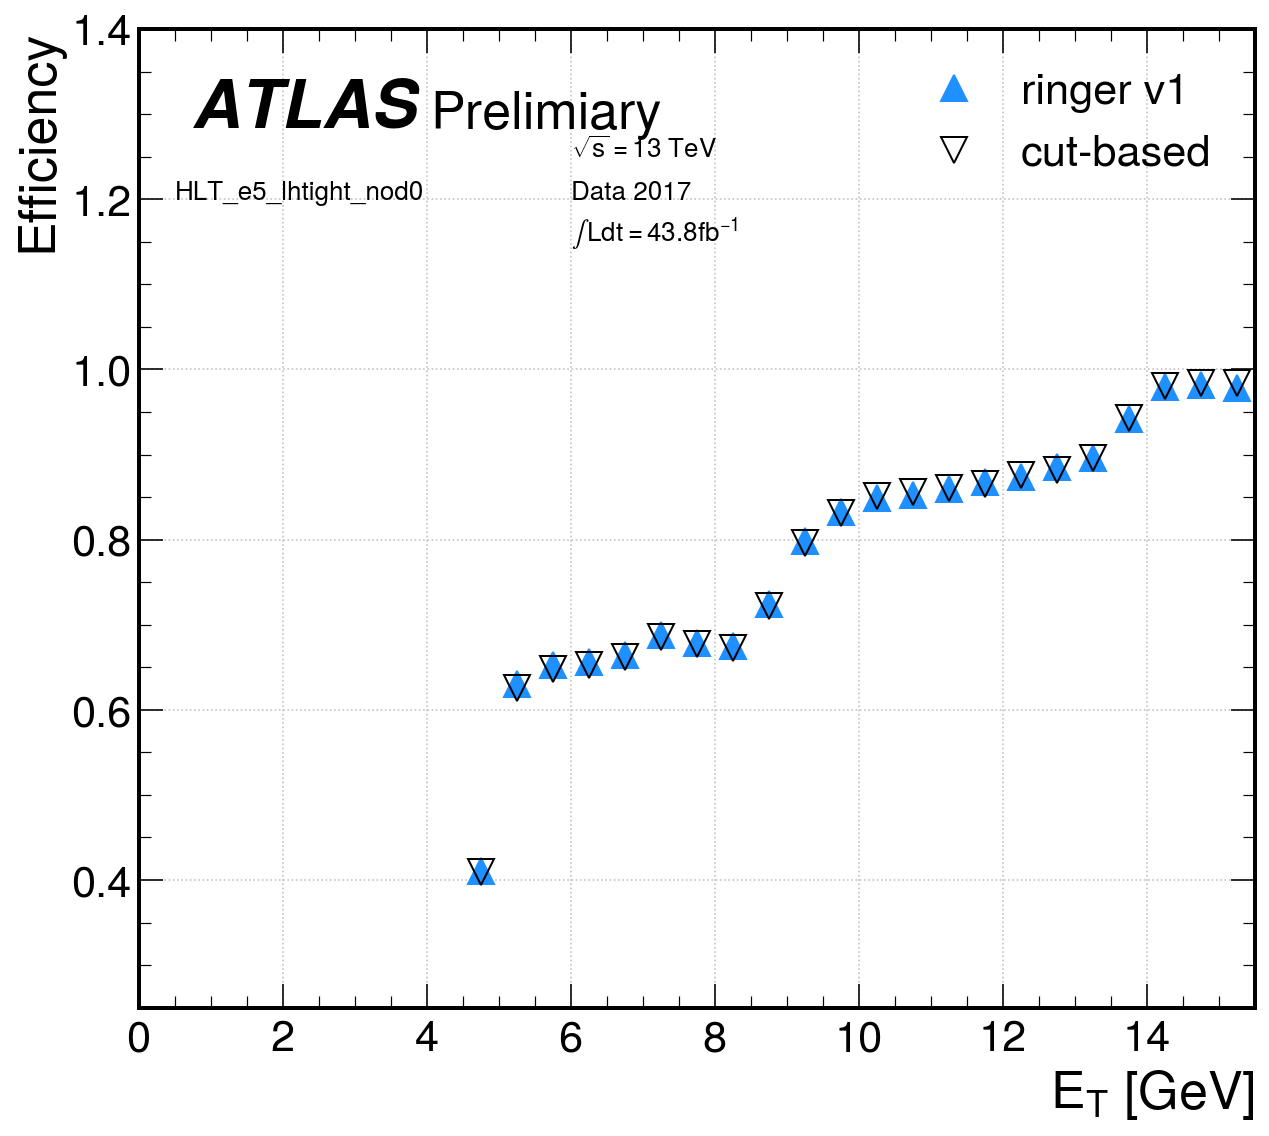

In [96]:
from Gaugi.constants import GeV

m_bins = np.arange(3, 16, step=.5)

t_counts, t_edges= np.histogram(m_df.loc[(m_df.target == 1) & (m_df.el_lhtight == 1)]['el_et']/GeV, bins=m_bins)

m_counts, m_edges= np.histogram(m_df.loc[((m_df.target == 1) & \
                                         (m_df.el_lhtight == 1) & \
                                         (m_df.HLT_e5_lhtight_nod0_ringer_v1 == 1))]['el_et']/GeV, bins=m_bins)

c_counts, c_edges= np.histogram(m_df.loc[(m_df.target == 1) & \
                                         (m_df.el_lhtight == 1) & \
                                         (m_df.HLT_e5_lhtight_nod0_noringer == 1)]['el_et']/GeV, bins=m_bins)

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(m_bins[0 : -1] + np.diff(m_bins)/2, m_counts/t_counts, '^', label='ringer v1', markersize=13, color='dodgerblue')
ax.plot(m_bins[0 : -1] + np.diff(m_bins)/2, c_counts/t_counts, 'v', label='cut-based', markersize=13, fillstyle='none', color='black')
ax.set_ylim([.25, 1.4])
ax.set_xlim([0, 15.5])
ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$E_T$ [GeV]')
plt.legend()
hep.atlas.text('Prelimiary', ax=ax, loc=1)
ax.text(x=0.5, y=1.2, s='HLT_e5_lhtight_nod0', fontsize=13)
ax.text(x=6, y=1.25, s='$\sqrt{s} = 13$ TeV', fontsize=13)
ax.text(x=6, y=1.2, s='Data 2017', fontsize=13)
ax.text(x=6, y=1.15, s='$\int\, Ldt = 43.8 fb^{-1}$', fontsize=13)

plt.grid()

In [48]:
t_counts

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
bins = np.linspace

In [ ]:
df = df.reset_index(drop=True)

## Plot Efficiencies:

In [ ]:
from kepler.analysis.efficiency import Efficiency
eff = Efficiency('my_efficiencies.root')

In [ ]:
eff.fill(df[df.target==1], 'e28_lhtight_nod0_ivarloose' , pidname = 'el_lhtight')
eff.fill(df[df.target==1], 'e28_lhtight_nod0_noringer_ivarloose' , pidname = 'el_lhtight')

In [ ]:
eff.save()

In [ ]:
eff_eta_e28 = eff.profile( 'HLT_e28_lhtight_nod0_ivarloose', 'eta' )
eff_eta_e28_noringer = eff.profile( 'HLT_e28_lhtight_nod0_noringer_ivarloose', 'eta' )

## Plot Quadrants:

In [ ]:
from kepler.analysis.quadrant.Quadrant import Quadrant
quad = Quadrant( "my_quadrant.root" )

In [ ]:
quad.fill( df[df.target==1],  'HLT_e28_lhtight_nod0_ivarloose', 'HLT_e28_lhtight_nod0_noringer_ivarloose', 'el_lhtight')

In [ ]:
quad.save()